In [26]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import json
import shutil
import math


from analytic_wfm.peakdetect import *
import cloudpickle
from datetime import datetime
import time

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [2]:
# Copie des fichiers .event pour aide export en .txt
copy_event_file("..\Millau\Resultats")
# copy_event_file("..\Normandie")

In [3]:
# Sélection des meilleurs signaux pour chacun des camions représentés par un fichier .txt
trucks_millau = select_all_best_signal('../Millau/Resultats/All_event', backup_path="backup/backup_trucks_millau.json")
# trucks_normandie = select_all_best_signal('../Normandie/All_event', backup_path="backup/backup_trucks_normandie.json")

In [4]:
# Récupération des csv contenant les informations de charges
millau = pd.read_csv('../Millau/Resultats/Fichiers Excel/millau_df_model.csv', index_col=0)
# normandie = pd.read_csv('../Normandie/Fichiers Excel/normandie_df_model.csv', index_col=0)

In [5]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau = find_trucks_in_csv(trucks_millau, millau, "backup_trucks_coor_millau.json")
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json

In [6]:
# Création des class Signal
trucks_sig_millau = create_signal_instance(trucks_coor_millau, filename="class_trucks_millau.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [7]:
# Création DataFrame global Millau
all_df = pd.DataFrame()
for key, value in trucks_sig_millau.items():
    all_df = pd.concat([all_df, value.to_df()])
all_df = all_df.reset_index(drop=True).sort_index()

Le pic 4.9707 du signal 2017-06-20-12-31-25-246 a eu un problème sur le calcul des fwhms.
Le pic 4.86133 du signal 2017-06-21-14-31-28-257 a eu un problème sur le calcul des fwhms.


In [8]:
# Remplacer 'max' par 1
all_df.replace(to_replace='max', value=1, inplace=True)

# Remplacer 'min' par 2
all_df.replace(to_replace='min', value=2, inplace=True)

In [9]:
all_df = pd.concat([timestamp_dummies(all_df['name']), all_df], axis=1)
all_df.drop(['name'], axis=1, inplace = True)

In [10]:
# Complétion NaN
all_df.fillna(-1, inplace=True)

### Test de modèle

In [11]:
loads = list_multiple_var('load_', var_to=8)
Y = all_df[loads]
X = all_df.drop(loads, axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [13]:
kms = KMeans(init='k-means++', n_clusters=2, random_state=42)
kms.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [14]:
predicted = kms.predict(X_train)

In [19]:
X_train.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde',
       'amplitude_0', 'amplitude_1', 'amplitude_10', 'amplitude_11',
       'amplitude_12', 'amplitude_13', 'amplitude_14', 'amplitude_15',
       'amplitude_16', 'amplitude_17', 'amplitude_18', 'amplitude_19',
       'amplitude_2', 'amplitude_20', 'amplitude_21', 'amplitude_22',
       'amplitude_3', 'amplitude_4', 'amplitude_5', 'amplitude_6',
       'amplitude_7', 'amplitude_8', 'amplitude_9', 'fwhm_0', 'fwhm_1',
       'fwhm_10', 'fwhm_11', 'fwhm_12', 'fwhm_13', 'fwhm_14', 'fwhm_15',
       'fwhm_16', 'fwhm_17', 'fwhm_18', 'fwhm_19', 'fwhm_2', 'fwhm_20',
       'fwhm_21', 'fwhm_22', 'fwhm_3', 'fwhm_4', 'fwhm_5', 'fwhm_6', 'fwhm_7',
       'fwhm_8', 'fwhm_9', 'kind_0', 'kind_1', 'kind_10', 'kind_11', 'kind_12',
       'kind_13', 'kind_14', 'kind_15', 'kind_16', 'kind_17', 'kind_18',
       'kind_19', 'kind_2', 'kind_20', 'kind_21', 'kind_22', 'kind_3',
       'kind_4', 'kind_5', 'kind_6', 'kind_7', 'kind_8',

In [27]:
# k parmi n
k = 2
n = 39
nbr_combinaison = math.factorial(n)/(math.factorial(k)*math.factorial(n-k))

In [28]:
nbr_combinaison

741.0

In [34]:
max_ = 5

In [48]:
ampl_name = list_multiple_var("amplitude_", var_from=0, var_to=max_)
fwhm_name = list_multiple_var("fwhm_", var_from=0, var_to=max_)
time_name = list_multiple_var("time_", var_from=0, var_to=max_)
kind_name = list_multiple_var("kind_", var_from=0, var_to=max_)
list_var = [ampl_name, fwhm_name, time_name, kind_name]

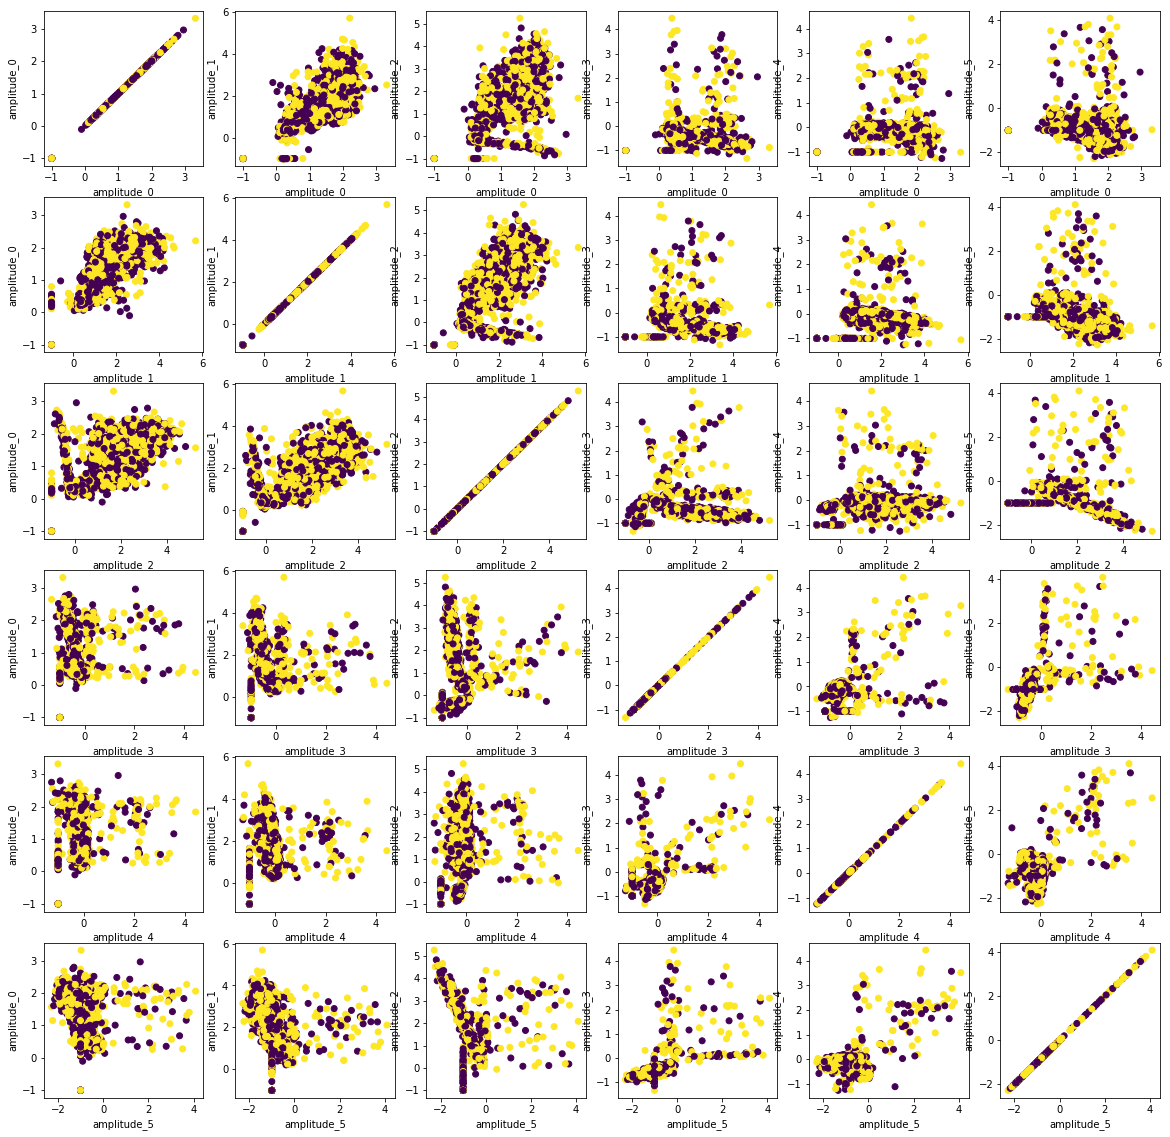

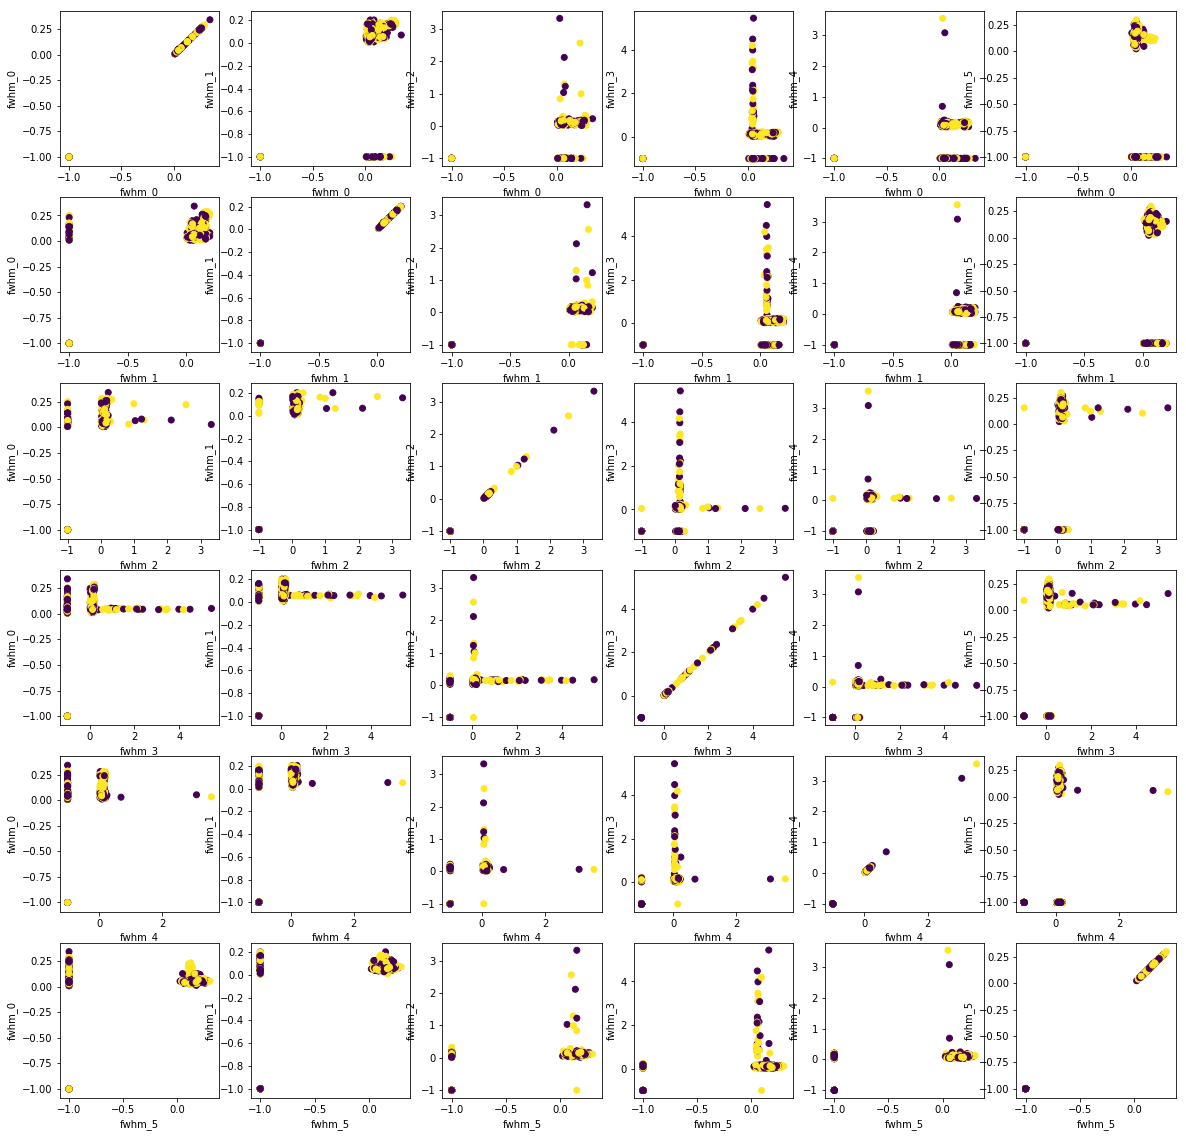

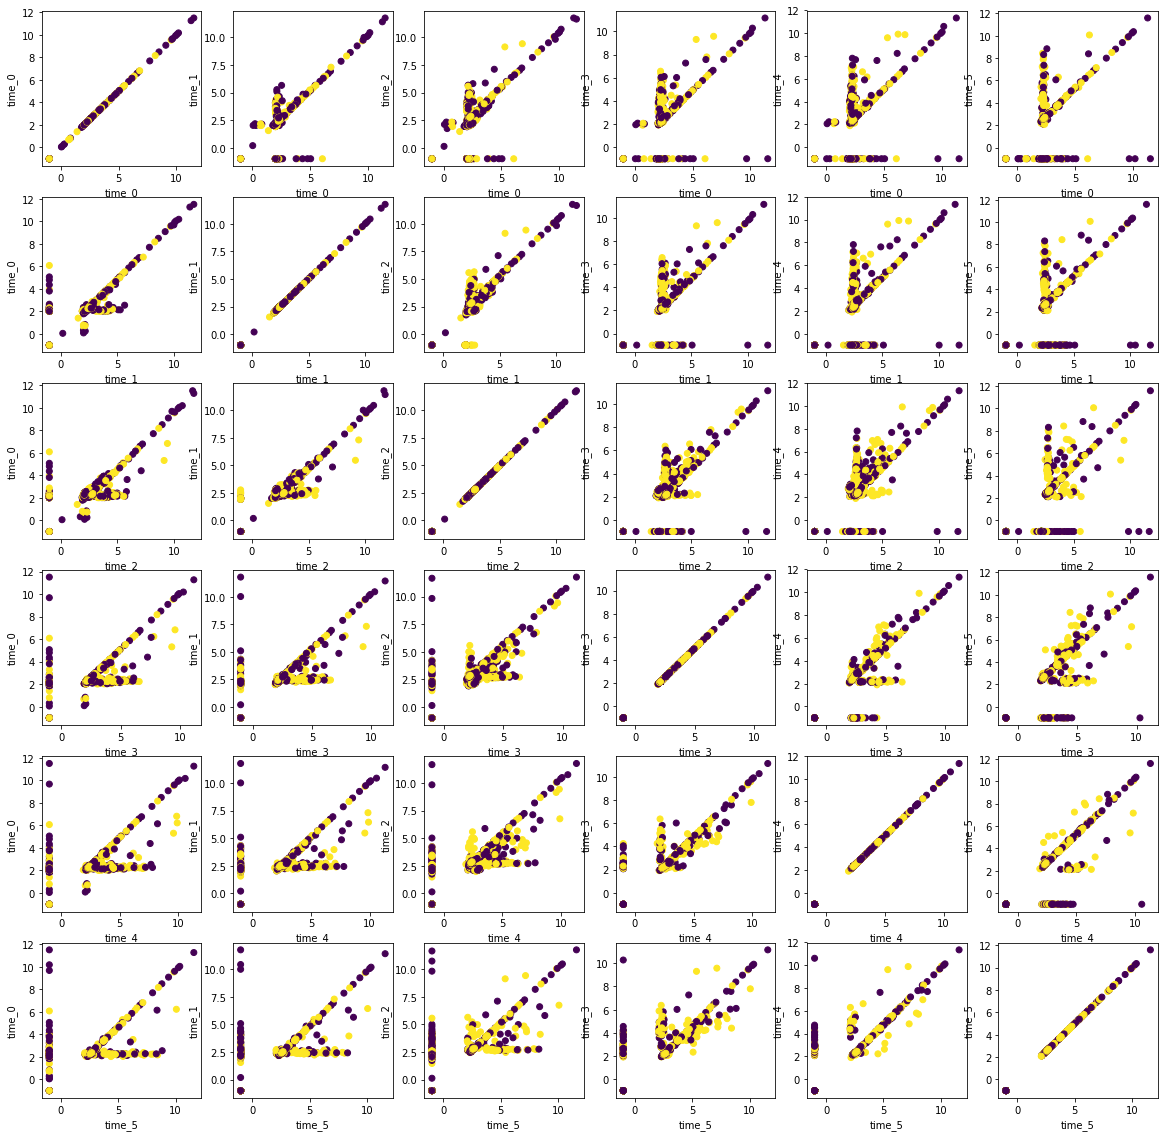

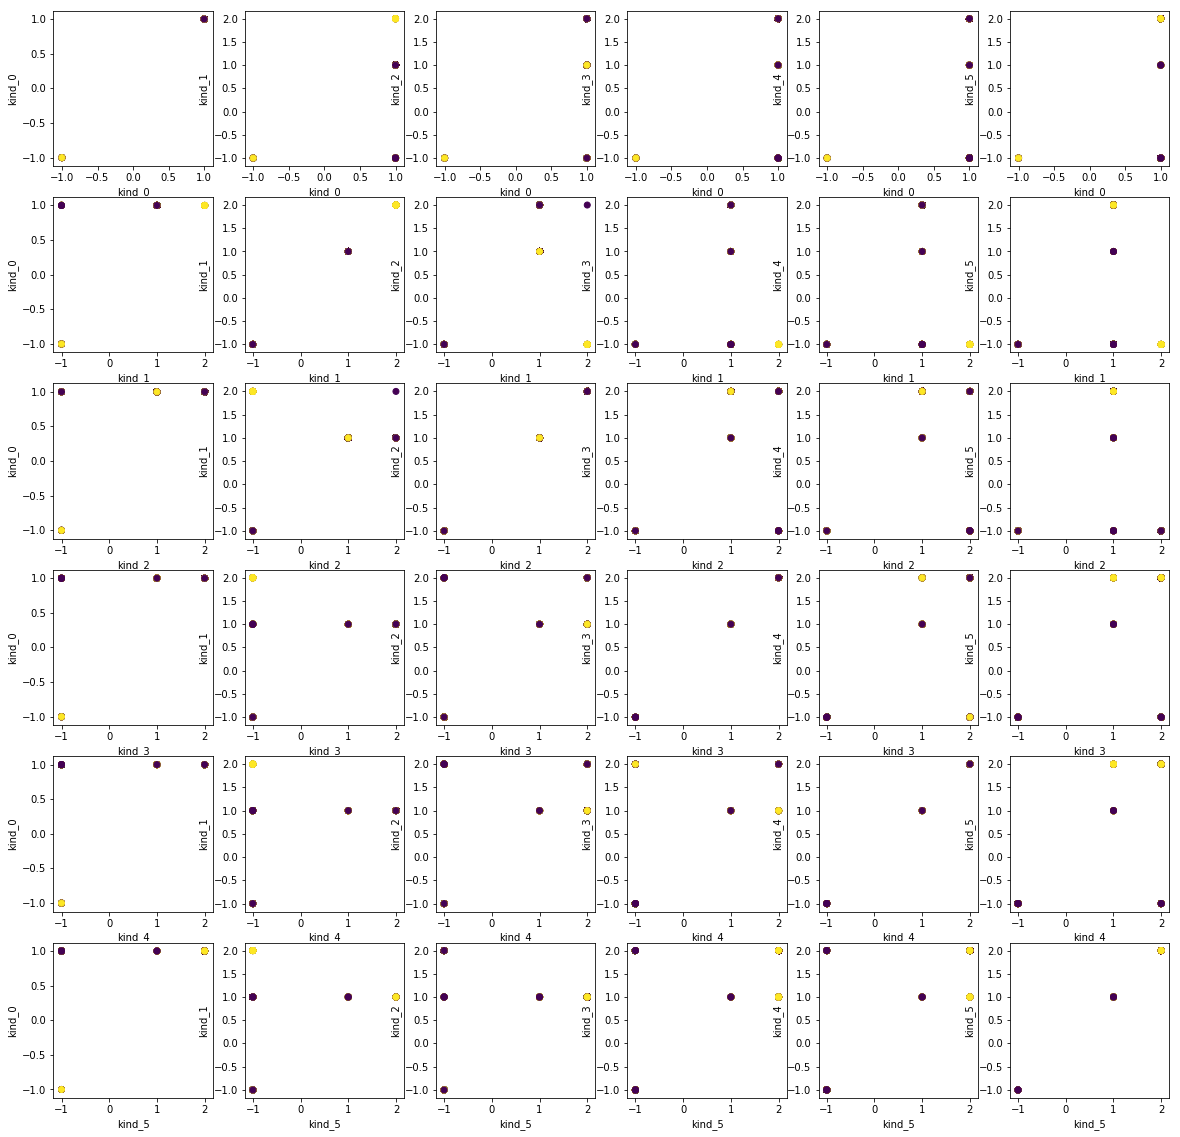

In [50]:
# Regrouppement variable par variable sur 5 élements
for var in list_var:
    plt.figure(figsize=(20,20))
    k=0
    for i in range(max_+1):
        for j in range(max_+1):
            k+=1
            plt.subplot(max_+1, max_+1, k)
            plt.scatter(X_train[var[i]], X_train[var[j]], c=predicted)
            plt.xlabel(var[i])
            plt.ylabel(var[j])

    plt.show()

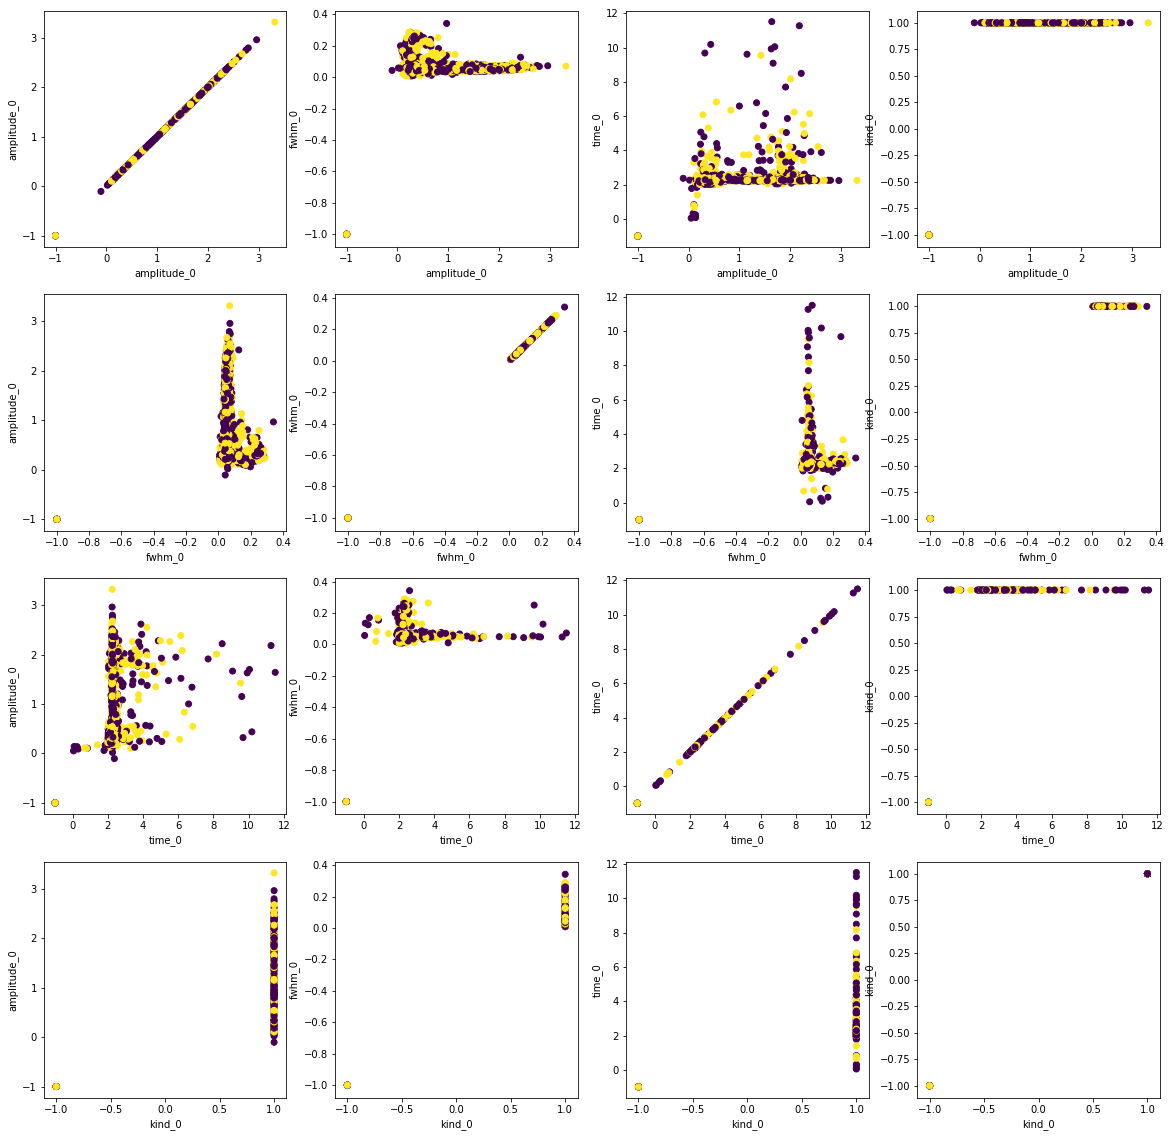

In [52]:
# Regroupement différente variables sur 1er élément
plt.figure(figsize=(20,20))
k=0
for i in list_var:
    for j in list_var:
        k+=1
        plt.subplot(len(list_var), len(list_var), k)
        plt.scatter(X_train[i[0]], X_train[j[0]], c=predicted)
        plt.xlabel(i[0])
        plt.ylabel(j[0])

plt.show()

In [ ]:
scatter_matrix(all_df)

In [ ]:
axes = scatter_matrix(X_train, alpha=0.2)

In [ ]:
plt.tight_layout()
plt.savefig('scatter_matrix.png')

#### Regression linéraire

In [17]:
regr = LinearRegression()
param = {
    "fit_intercept" : [True, False],
    "normalize" : [True, False],
    "copy_X" : [True, False],
    "n_jobs" : [1, 2]
}

In [18]:
clf = GridSearchCV(regr, param, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False], 'n_jobs': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [19]:
# Negate to have the MSE
-clf.best_score_

38.20993770625592

In [196]:
predicted = clf.predict(X_train)

In [197]:
mean_squared_error(y_train, predicted)

3.3131290769520105

In [198]:
predicted = clf.predict(X_test)

In [199]:
mean_squared_error(y_test, predicted)

32.24013258969341

#### RandomForest

In [64]:
rfr = RandomForestRegressor()
param = {
    "n_estimators" : [500, 1000, 2000],
    "max_features" : [30, 50, 80],
    "max_depth": [30, 50, 100],
    "min_samples_leaf" : [1, 2, 3],
    "bootstrap" : [True, False]
}

In [65]:
clf = GridSearchCV(rfr, param, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500, 1000, 2000], 'max_features': [30, 50, 80], 'max_depth': [30, 50, 100], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [66]:
clf.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 30,
 'min_samples_leaf': 1,
 'n_estimators': 500}

In [67]:
# Negate to have the MSE
-clf.best_score_

3.149767137204441

In [68]:
predicted = clf.predict(X_train)

In [69]:
mean_squared_error(y_train, predicted)

0.41378922119467904

In [70]:
predicted = clf.predict(X_test)

In [71]:
mean_squared_error(y_test, predicted)

3.2871527878003506